In [58]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
sys.path.insert(1, '../utils')
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from utils.declarations import training_files, testing_files, POSE_MAP

In [59]:
training_csv = training_files["001"].csv_file
training_annot = training_files["001"].annot_file
testing_csv = testing_files["001"].csv_file
testing_annot = testing_files["001"].annot_file

x_train_wrapper = df_wrapper(training_csv)
x_train_wrapper.concat_sensor_data(3)
x_train_wrapper.align_poses(training_annot, POSE_MAP)

print("x_train shape before drop: ", np.shape(x_train_wrapper.df))

y_train = x_train_wrapper.df['Pose']
x_train = x_train_wrapper.df.drop([' TimeStamp (s)', 'Pose'],axis=1)


print("x_train shape after drop: ", np.shape(x_train))
print("y_train shape after drop: ", np.shape(y_train))


..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
x_train shape before drop:  (52824, 41)
x_train shape after drop:  (52824, 39)
y_train shape after drop:  (52824,)


In [60]:
print(x_train)

        AccX (g)   AccY (g)   AccZ (g)   GyroX (deg/s)   GyroY (deg/s)  \
0       0.019920  -0.794387  -0.601370       -1.562904       -1.464186   
1       0.015635  -0.798804  -0.605099       -1.746947       -0.781661   
2       0.015153  -0.801027  -0.604974       -0.723603        0.261424   
3       0.020163  -0.797502  -0.608591       -0.445173        0.111246   
4       0.026463  -0.787940  -0.609870       -0.919388       -0.897010   
...          ...        ...        ...             ...             ...   
54053  -0.725738  -0.097731  -0.669750       -1.138789       -0.842105   
54054  -0.727689  -0.091215  -0.661862        1.055157       -1.241417   
54055  -0.707818  -0.083994  -0.657991       -0.059204       -1.188114   
54056  -0.687590  -0.088312  -0.649707       -3.103736        0.579363   
54057  -0.703201  -0.092101  -0.660801       -4.215070       -1.473026   

        GyroZ (deg/s)   EulerX (deg)   EulerY (deg)   EulerZ (deg)     QuatW  \
0           -0.498630      52.0

<AxesSubplot:xlabel=' TimeStamp (s)', ylabel='Pose'>

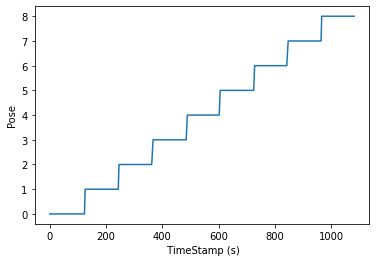

In [61]:
sns.lineplot(data=x_train_wrapper.df, x=" TimeStamp (s)", y="Pose")

In [62]:
# Create numpy arrays
x_train_numpy = x_train.values
y_train_numpy = y_train.values

# Hot encode categories into numbers
#y_train = to_categorical(y_train_numpy,9)

print(x_train_numpy.shape)
print(y_train_numpy.shape)


(52824, 39)
(52824,)


In [63]:

from scipy import stats

NUM_TIMESTAMPS = 50

def create_3d_array(array, num_timestamps):

    arr_3d = []
    temp_2d = []
    for i in range(1,len(array)):
        temp_2d.append(array[0])
        if i % NUM_TIMESTAMPS == 0:
            arr_3d.append(temp_2d)
            temp_2d = []
    
    return arr_3d

def create_2d_y_array(array, num_timestamps):
    arr_2d_y_train = []
    temp_y_train = []
    mode_arr = []

    for i in range(1,len(array)):
        #temp_2d.append(array[0])
        temp_y_train.append(array[i])
        if i % NUM_TIMESTAMPS == 0:
            mode_arr.append(temp_y_train)

            temp_y_train = []
            #temp_2d = []

    y_train_to_be_encoded = []

    for i in range(len(mode_arr)):
        mode = stats.mode(mode_arr[i])
        y_train_to_be_encoded.append(mode.mode[0])

    #ONE HOT ENCODING
    encoding = []
    for value in y_train_to_be_encoded:
        vector = [0 for _ in range(9)]
        vector[value] = 1
        encoding.append(vector)
    
    return np.array(encoding)




In [93]:

x_train = np.array(create_3d_array(x_train_numpy, NUM_TIMESTAMPS))
y_train = np.array(create_2d_y_array(y_train_numpy, NUM_TIMESTAMPS))
print(np.shape(x_train))
print(np.shape(y_train))


(1056, 50, 39)
(1056, 9)


In [94]:
from keras.layers import LSTM
from tensorflow.keras import layers

OPTIM = SGD(learning_rate=0.008)

model = Sequential()
model.add(LSTM(2, stateful=True, batch_input_shape=(60,50,39), input_shape=[x_train.shape[1], x_train.shape[2]]))
model.add(Dropout(rate=0.3))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer=OPTIM,  loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [95]:

#model.fit(x=np.array(arr_3d_x_train), batch_size=512, y=y_train, shuffle=False, epochs=10)

model.fit(x=x_train, y=y_train, batch_size=60, epochs=100)
#model.reset_states()



Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2.3167 - accuracy: 0.0985 

InvalidArgumentError:    Specified a list with shape [60,39] from a tensor with shape [36,39]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_24/lstm_28/PartitionedCall]] [Op:__inference_train_function_130178]

Function call stack:
train_function -> train_function -> train_function
